In [8]:
from Utils.Config import DATA_DIR
from Utils.Config import CHARTS_DIR
from Utils import dataUtils
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [9]:
files_1 = dataUtils.getDataPaths(1)
files_2 = dataUtils.getDataPaths(2)
files_3 = dataUtils.getDataPaths(3)
files_3 = dataUtils.getDataPaths(4)
files = files_1 + files_2 + files_3
dfs = dataUtils.concat_dfs("prices",files)
dfs.head(3)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_3,mid_price,profit_and_loss,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY
0,-1.0,0,AMETHYSTS,10002.0,1.0,9996.0,2.0,9995.0,29.0,10004.0,...,NaN,10003.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0,0,STARFRUIT,5045.0,1.0,5040.0,31.0,NaN,NaN,5047.0,...,NaN,5046.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.0,100,STARFRUIT,5040.0,24.0,NaN,NaN,NaN,NaN,5046.0,...,NaN,5043.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. COCONUTS EDA

- > COCONUTS: it is the underlying product that we will research to see how to predict it or enter positions
- > COUPONS: are call options to buy at a given price at the end of the iterations. So if we are buying a call option we will buy at that price in the future before we sell it. If we short it it is the opposite.


array([ 2.,  9.,  5., 10.,  8.,  7.,  6.,  1.,  3.,  4.])

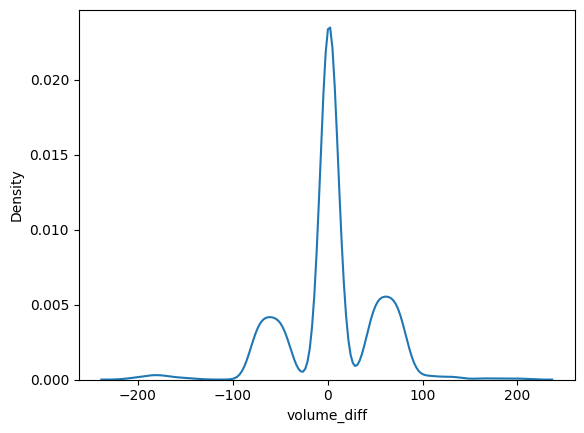

In [513]:
coconut_prices = dataUtils.getDataPaths(4)
df_coco_prices = dataUtils.concat_dfs("prices",coconut_prices)
df_coco_trades = dataUtils.concat_dfs("trades",coconut_prices)


coupon_prices = df_coco_prices[df_coco_prices["product"]=="COCONUT_COUPON"]
coupon_trades = df_coco_trades[df_coco_trades["symbol"]=="COCONUT_COUPON"]
coco_prices = df_coco_prices[df_coco_prices["product"]=="COCONUT"]
coco_trades = df_coco_trades[df_coco_trades["symbol"]=="COCONUT"]


coco_prices = coco_prices.join(coco_trades.set_index("timestamp"), on="timestamp", rsuffix="quantity")

search_trades = coco_prices[coco_prices["currency"] == "SEASHELLS"][["timestamp","mid_price","quantity","bid_price_1","ask_price_1","ask_volume_1","bid_volume_1"]]
search_trades["volume_diff"] = search_trades["ask_volume_1"] -search_trades["bid_volume_1"]

sns.kdeplot(search_trades["volume_diff"])

> Quantity is Key at this round

In [536]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = np.array(search_trades.quantity.values).reshape(-1,1)
y = np.array(search_trades.mid_price.values).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model = LinearRegression()
model.fit(X,y)
preds = model.predict(X_test)
print(mean_squared_error(y_test,preds))


7934.263295164613


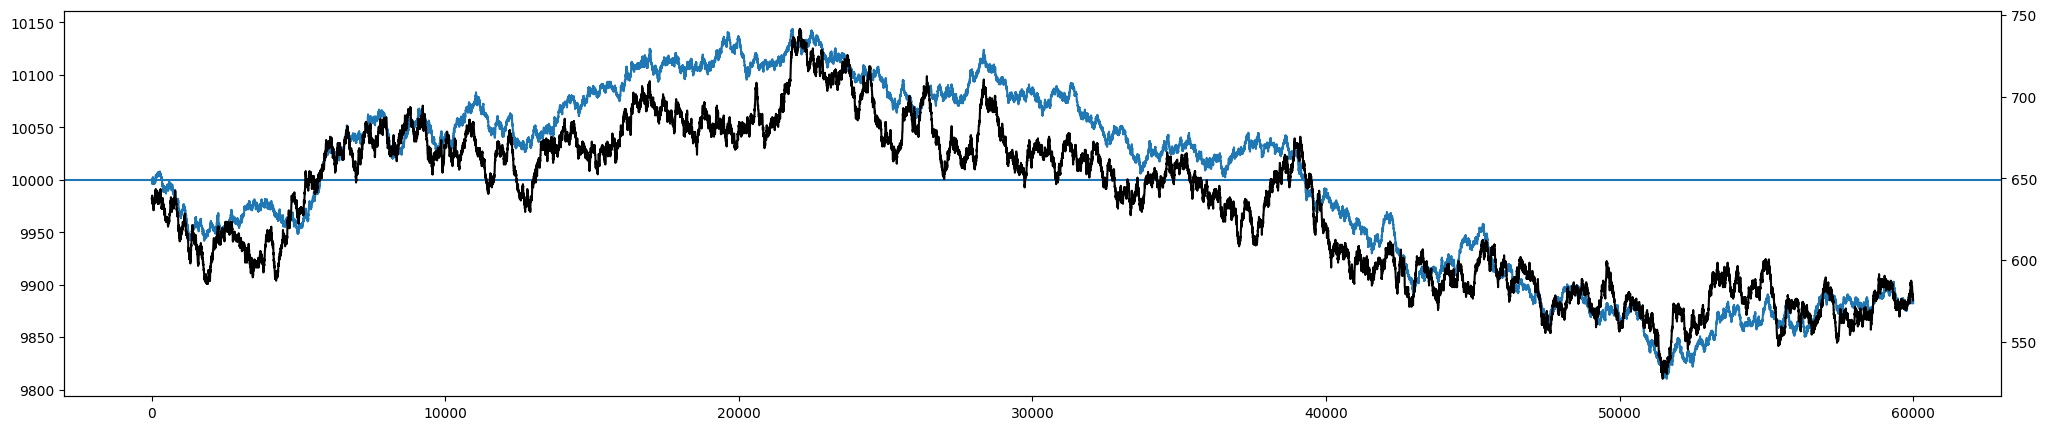

In [11]:
cocos_per_option = coupon_prices.mid_price.values / coco_prices.mid_price.values

fig, axs = plt.subplots(figsize=(25,5))
axs.plot(coco_prices.mid_price)
ax2 = axs.twinx()
ax2.plot(coupon_prices.mid_price, color="black")
axs.axhline(10000)

In [12]:
from dataUtils import savitzky_golay

[0 0 1 ... 0 0 0]


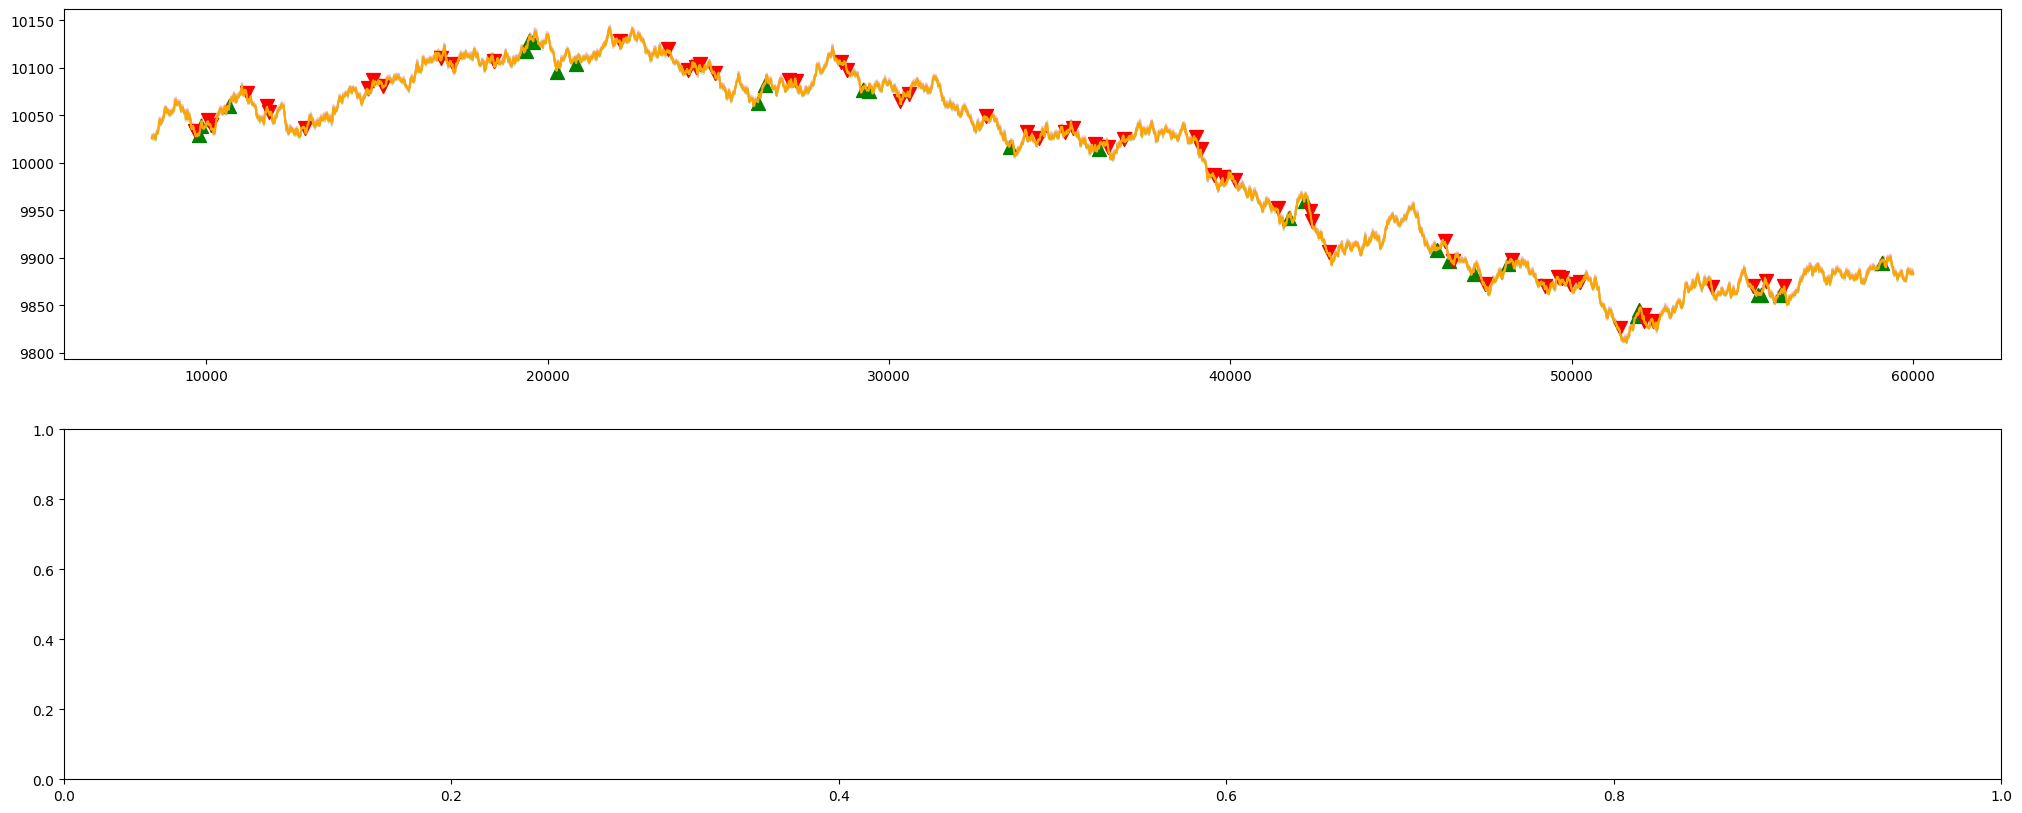

In [447]:
filter_parameter = 1

l,h = 4200,53000
bid = coco_prices.bid_price_1[l:h]
ask = coco_prices.ask_price_1[l:h]
mid_price = coco_prices.mid_price[l:h]
savgol = np.int32(savitzky_golay(mid_price.values, window_size=11, order=filter_parameter))
trend = np.sign(np.diff(savgol))
trend = np.insert(trend, 0, 0)
print(trend)

sav_ask, sav_bid =  np.int32(savitzky_golay(ask.values, window_size=11, order=filter_parameter)), np.int32(savitzky_golay(bid.values, window_size=11, order=filter_parameter))
spread = ask-bid
sav_spread = sav_ask-sav_bid
mean_spread = np.mean(spread)
my_ask, my_bid = savgol + spread, savgol - spread


minim, maxim = np.min(savgol), np.max(savgol)

buy_signals = np.where((ask < sav_bid) & ((trend == 1)),2,0)
sell_signals = np.where((bid > sav_ask) &  ((trend == -1) & (spread > 1)),1,0)

idx_buy = np.where(buy_signals == 2)[0]
idx_sell = np.where(sell_signals == 1)[0]

fig, axs = plt.subplots(2,1, figsize=(25,10))
x = mid_price.index
axs[0].scatter(x[idx_buy], ask.iloc[idx_buy], color='g', marker='^', s=100)
axs[0].scatter(x[idx_sell], bid.iloc[idx_sell], color='r', marker='v', s=100)
axs[0].plot(x,ask, color="red",alpha=0.2)
axs[0].plot(x,bid, color="green",alpha=0.2)
# axs[0].plot(x,my_ask, color="red", linestyle="dashed")
# axs[0].plot(x,my_bid, color="green", linestyle="dashed")
# axs[0].plot(x,sav_ask,color="r")
# axs[0].plot(x,sav_bid,color="g")
axs[0].plot(x,savgol,color="orange")


ValueError: x and y must have same first dimension, but have shapes (4200,) and (2500,)

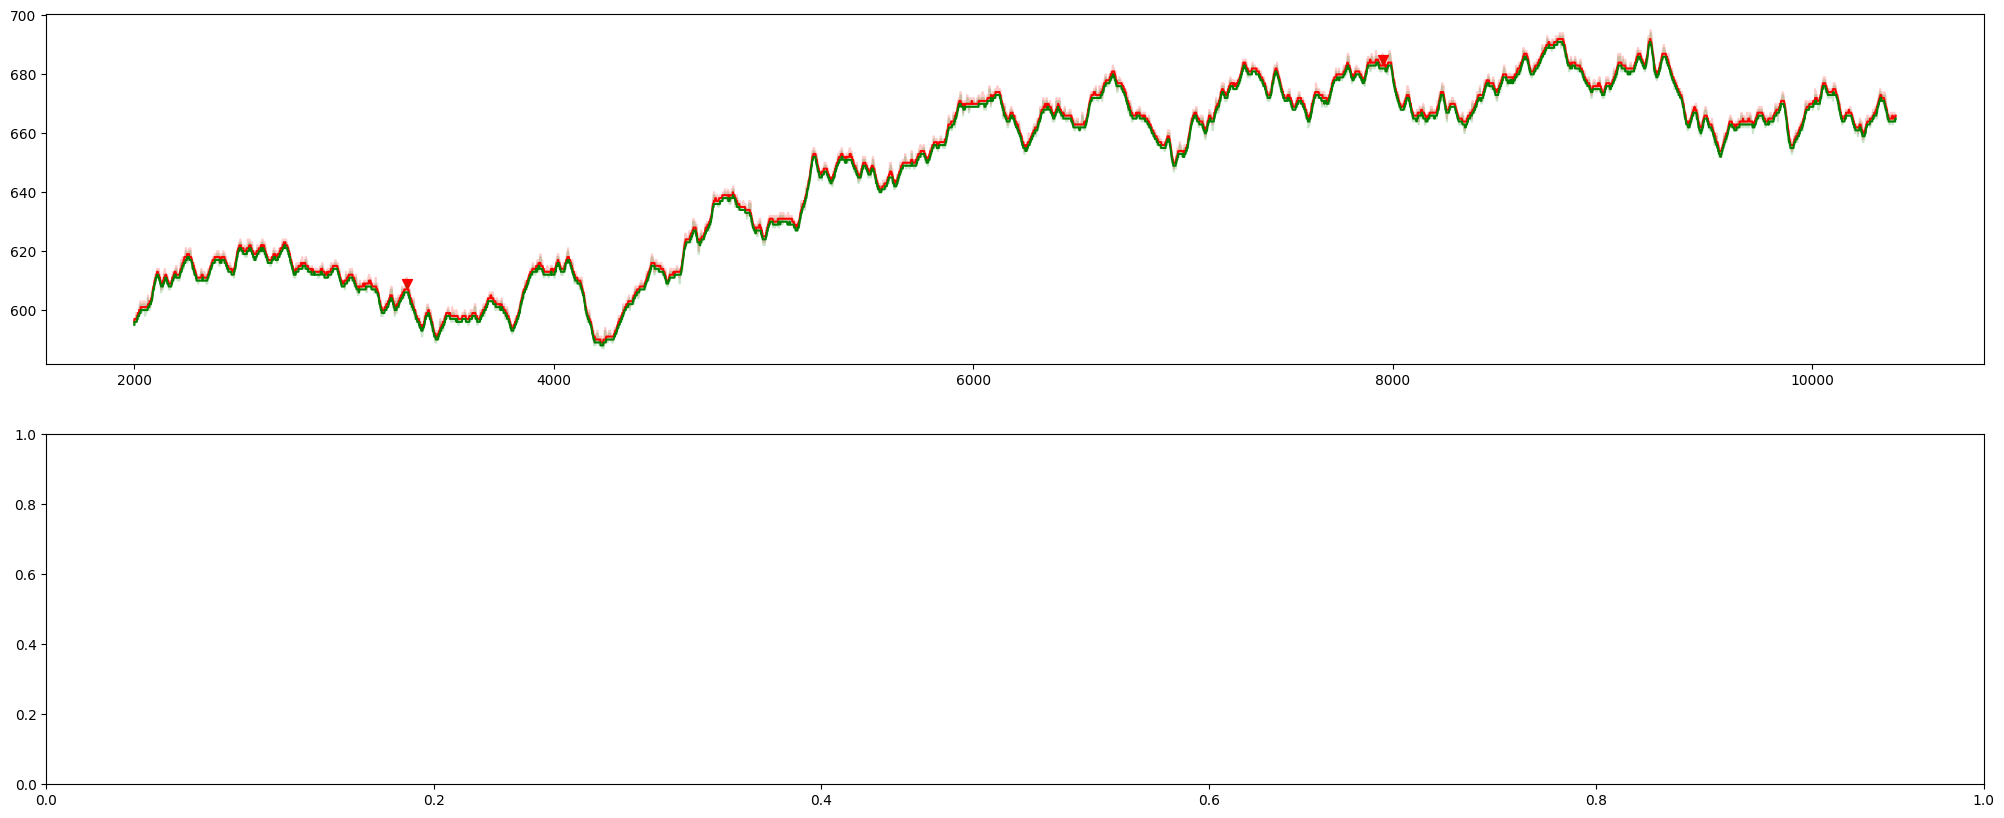

In [313]:
filter_parameter = 1

bid = coupon_prices.bid_price_1[1000:5200]
ask = coupon_prices.ask_price_1[1000:5200]
mean_spread = np.mean(spread)
mid_price = coupon_prices.mid_price[1000:5200]
savgol = np.int32(savitzky_golay(mid_price.values, window_size=11, order=filter_parameter))
sav_ask, sav_bid =  np.int32(savitzky_golay(ask.values, window_size=11, order=filter_parameter)), np.int32(savitzky_golay(bid.values, window_size=11, order=filter_parameter))
spread = ask-bid
my_ask, my_bid = savgol + spread, savgol - spread


minim, maxim = np.min(savgol), np.max(savgol)

buy_signals = np.where((ask+1 < sav_bid) & (spread==2),1,0)
sell_signals = np.where((bid-1 > sav_ask) & (spread==2),1,0)
idx_buy = np.where(buy_signals == 1)[0]
idx_sell = np.where(sell_signals == 1)[0]

fig, axs = plt.subplots(2,1, figsize=(25,10))
x = mid_price.index
axs[0].scatter(x[idx_buy], ask.iloc[idx_buy], color='g', marker='^', s=50)
axs[0].scatter(x[idx_sell], bid.iloc[idx_sell], color='r', marker='v', s=50)
axs[0].plot(x,ask, color="red",alpha=0.2)
axs[0].plot(x,bid, color="green",alpha=0.2)
# axs[0].plot(x,my_ask, color="red", linestyle="dashed")
# axs[0].plot(x,my_bid, color="green", linestyle="dashed")
axs[0].plot(x,sav_ask,color="r")
axs[0].plot(x,sav_bid,color="g")
axs[1].plot(x,sav_spread)
axs[1].axhline(int(mean_spread))

# Black Scholes model

In [26]:
volatility = np.std(coco_prices.mid_price.pct_change())
volatility

0.00010293789384209994

In [30]:
a = -19
b = -10
np.max([a,b])

-10

In [25]:
(np.round(-9.900884166666014)/100) * 300


-30.0